# CMM536 - Image classification algorithms comparison

Machine learning comes with many algorithms such as detection, recognition, classification and so on. Within this piece, we will be focusing on the classification algorithm of multimedia - images. The context of the multimedia is the current global situation that shifted the way we normally do activities. The Covid-19 pandemic forces us to wear masks in public spaces, where for security purposes, the face recognition systems are facing impediments. To improve the system, we need to have a good understanding of the tools available. To do so we will use data sets of masked and unmasked people.
   
    

## 1. Data set selection

   The image repository is a mix of the repository [Real World Masked Face Dataset](https://github.com/X-zhangyang/Real-World-Masked-Face-Dataset) found on GitHub, and the repository [Face Mask Detection Dataset](https://www.kaggle.com/omkargurav/face-mask-dataset) from Kaggle. The mix brought in a variety of ethnicities (the GitHub repository has a majority of Chinese faces) and image quality (the Kaggle dataset contains images with greater resolution compared to the first dataset).
   
   The GitHub repository is created for face recognition, so the images were split into folders by the person wearing and not wearing a mask. Therefore, I have made my own hand selection of images and split them by mask and no mask images. The selection was on the criteria: the full face to be visible(as the dataset has the faces already cropped out), the face to not be turned to either side so much that half of the face is not visible, not wearing sunglasses, but vision glasses were accepted(the eyes will be visible). The same criteria were applied to the second dataset, but the face cropping was done manually - faces extraction, from this dataset, can be improved by applying face detection algorithms to the full image. The dataset is available on [Google Drive](https://drive.google.com/drive/folders/19jKp5NA7Q8_u1ezzYAwaBzWJb7OzGUgk?usp=sharing).

### 1.1. Added complexity

The face recognition algorithms will have an improved result when applying gender identification. Nevertheless, the simple model of gender classification can be used in demographics and building up target groups in a business.

Therefore, the two existing folders will be split into other two folders for the "Feminine" and "Masculine" genders. In this way, we will obtain a multi-class classification problem with 4 different classes.

## 2. Loading data 

The experiment will consist of creating a repository with the flattened arrays of the selected images, create four other variations, and compare four models trained with the five repositories created. The repositories will be created by applying the following methods:
1. Image Pre-processing
2. Feature extraction
3. Image augmentation
4. Class Decomposition

The following code will take each image from the `data` file, read it, resize it, append it to the repositories: flattened pixels, binarised pixels, and the extracted features; and add the class in the `target` list.


In [1]:
# The packages that will be used throughout the report
import os # Operating System
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import tensorflow as tf
import random
import math
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import copy
from keras.utils import np_utils
import warnings; warnings.simplefilter('ignore') #Ignore warnings

os.environ['KERAS_BACKEND'] = 'tensorflow' # Setting the backend for Keras to be TensorFlow
np.random.seed(250) # Random seed set for reproductibility

In [2]:
# resizing dimensions - keep a portrait shape with number of pixels powers of 2 so HOG feature extraction will meet no problems and avoiding large repositories
standard_width = 64
standard_height = 128

path = 'data' # the images are in the folder data

images = [] # List of images as 2D arrays with colours
target = [] # List of classes
original_repo = [] # Repository of flatten pixels
thresh_repo = [] # Repository of binarised pixels
hog_repo = [] # Repository of the HOG features
aug_repo = [] # Repository of the augmented images
aug_target = [] # The classes list associated with the balanced repository
cl_decompose = [] # The class decomposed target list


for root, dirs, files in os.walk(path):
    for file in files:
        with open(os.path.join(root, file), 'r') as auto:
            img = cv2.imread(root + '/' + file, 1) # coloured images
            img = cv2.resize(img, (standard_width, standard_height))
            # Tensorflow augmentation requires the images to be three-dimensional 
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # append the coloured image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
            original_repo.append(img.flatten())
            thresh_repo.append(cv2.threshold(img, 115, 255, cv2.THRESH_BINARY)[1].flatten()) # The threshold value is 125
            hog_repo.append(cv2.HOGDescriptor().compute(img))
            target.append(root.replace(path, '').replace('\\', '')) # Append the folder name where the image is located

original_repo = np.array(original_repo) #convert the list into a numpy array
thresh_repo = np.array(thresh_repo)
hog_repo = np.array(hog_repo)
#reshape the hog repository to fit the same 2D structure
hog_repo = np.reshape(hog_repo, (hog_repo.shape[0], hog_repo.shape[1]))

print('The original repository with the flatten images: \n', original_repo, original_repo.shape)
print('\nThe dataset has ' + str(original_repo.shape[0]) + ' images')
print('\nThe binarised repository: \n', thresh_repo, thresh_repo.shape)
print('\nThe HOG features repository: \n', hog_repo, hog_repo.shape)
print('\nThe set of the classes', set(target)) # Show just the classes and not the entire target list

The original repository with the flatten images: 
 [[167 183 194 ...  28  33  34]
 [ 10  11  11 ...  93 102 102]
 [ 60  63  59 ... 218 234 247]
 ...
 [182 182 183 ... 158 120 155]
 [233 185 161 ...  62  84  73]
 [ 28  31  29 ... 166 246 253]] (1395, 8192)

The dataset has 1395 images

The binarised repository: 
 [[255 255 255 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ...   0   0   0]
 [  0   0   0 ... 255 255 255]] (1395, 8192)

The HOG features repository: 
 [[0.06131222 0.19852245 0.24525715 ... 0.03565888 0.03582592 0.11416622]
 [0.4122207  0.4122207  0.29277456 ... 0.21248624 0.3118131  0.3118131 ]
 [0.23580399 0.21984808 0.13094525 ... 0.0939947  0.0586951  0.30481493]
 ...
 [0.20682646 0.23542686 0.11608373 ... 0.08408674 0.09668589 0.291585  ]
 [0.27562663 0.27562663 0.27562663 ... 0.16814555 0.2969459  0.2969459 ]
 [0.23247647 0.12942147 0.12052645 ... 0.13510017 0.33835942 0.39086434]] (1395

As we can see, there are 1395 images and the HOG feature repository has fewer features compared to the original and binarised repositories. 

The following cell will print random pictures to show how the threshold of __115__ is a sensible threshold.

<function matplotlib.pyplot.show(close=None, block=None)>

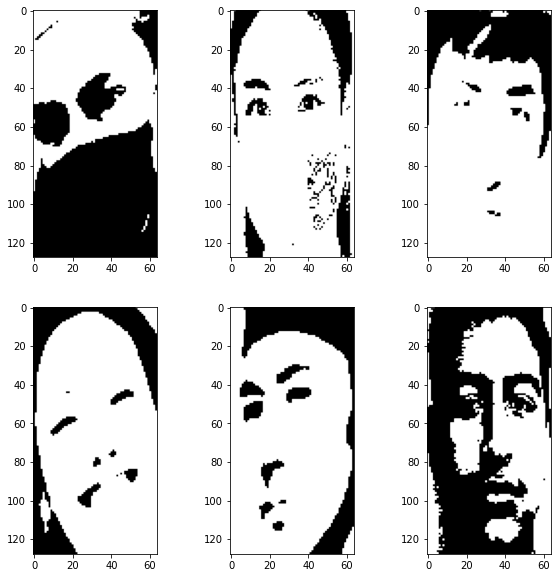

In [3]:
fig = plt.figure(figsize = (10, 10))
for i in range(1, 7):
    img = np.random.randint(1, 1395)
    fig.add_subplot(2, 3, i)
    plt.imshow(cv2.threshold(cv2.cvtColor(images[img], cv2.COLOR_RGB2GRAY), 115, 255, cv2.THRESH_BINARY)[1], cmap = 'Greys_r')
plt.show

### 2.1. Class distribution

With the following code, we will view the class distribution.

['mask_f' 'mask_m' 'no_mask_f' 'no_mask_m'] 
 [296 347 305 447]


<BarContainer object of 4 artists>

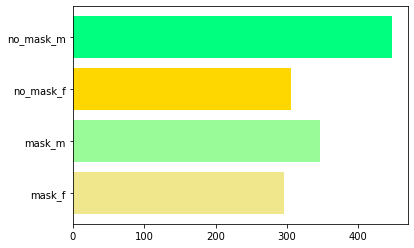

In [4]:
#Counting the instances for each class
class_list, class_count = np.unique(target, return_counts = True)

print(class_list,'\n', class_count)
plt.barh(class_list, class_count, color = ['khaki', 'palegreen', 'gold', 'springgreen'])

As we can see, the classes are imbalanced, although not heavily imbalanced. The classes are of the sizes:
- No masked male faces - __447__
- No masked female faces - __305__
- Masked male faces - __347__
- Masked female faces - __296__

As a binary problem (mask/no-mask), there are in total more images of no-masked faces than faces that wear masks. A fact which reflects the population data as there are more pictures of faces not wearing a mask.

### 2.2. Class balancing
Due to the class imbalance, we will apply image augmentation and therefore creating the fourth repository.


The augmented repository: 
 [[167. 183. 194. ...  28.  33.  34.]
 [ 10.  11.  11. ...  93. 102. 102.]
 [ 60.  63.  59. ... 218. 234. 247.]
 ...
 [182. 182. 183. ... 158. 120. 155.]
 [233. 185. 161. ...  62.  84.  73.]
 [ 28.  31.  29. ... 166. 246. 253.]] (1788, 8192)

 ['mask_f' 'mask_m' 'no_mask_f' 'no_mask_m'] 
 [447 447 447 447]


<BarContainer object of 4 artists>

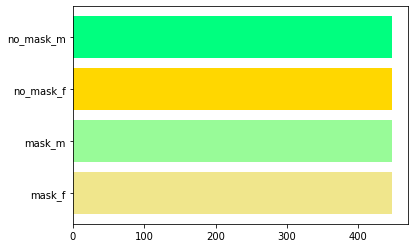

In [5]:
## Creating the augmented repository variant

# Defining the augmentation methods
# Changing the colour
def colour (x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_hue(x, 0.1)
    x = tf.image.random_saturation(x, 0.5, 1.5)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.2, 0.5)
    return x


def flip (x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x


def rotate (x: tf.Tensor) -> tf.Tensor:
    x = tf.image.rot90(x, tf.random.uniform(shape = [], minval = 0, maxval = 4, dtype = tf.int32))
    return x


def zoom (x: tf.Tensor) -> tf.Tensor:
    scales = list(np.arange(0.8, 1., 0.01))
    boxes = np.zeros((len(scales), 4))
    
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]
    
    def random_crop (img):
        crops = tf.image.crop_and_resize(image = [img], boxes = boxes, box_indices = np.zeros(len(scales)), crop_size = (standard_width, standard_height))
        return crops[tf.random.uniform(shape = [], minval = 0, maxval = len(scales), dtype = tf.int32)]
    
    choice = tf.random.uniform(shape = [], minval = 0., maxval = 1., dtype = tf.float32)
    return tf.cond(choice < .5, lambda: x, lambda: random_crop(x))



augmentations = [colour, flip, rotate, zoom]
aug_images = images # the list of the images to which adding the augmented images
aug_target = copy.deepcopy(target)

class_count = list(class_count)

## Now to balance the classes
# Make use of the lists: `class_list` and `class_count`
for no in class_count:
    y = max(class_count) - no # Obtaining the difference of how much to augment # maximum is picked for replicability
    class_item = class_list[class_count.index(no)] # Obtaining the name of the class with the count `no`
    
    for i in range(y):
        # Picking a random image to augment from the right interval
        if class_count.index(no) == 0:
            random_image = aug_images[random.randint(0, aug_target.count(class_item))]
        else:
            random_image = aug_images[random.randint(max(class_count) * class_count.index(no) + 1, max(class_count) * class_count.index(no) + aug_target.count(class_item))]
        
        new_image = random.choice(augmentations)(random_image) # Apply random augmenting function on the random picked image
        aug_images.insert(max(class_count) * class_count.index(no) + aug_target.count(class_item), new_image) # Add the new image created to the repository
        aug_target.insert(max(class_count) * class_count.index(no) + aug_target.count(class_item), class_item) # Add the class of the newly added image
        

aug_images = np.array(aug_images)

# Modify the `aug_repo` np.array into 2D structure
for imindex in range(aug_images.shape[0]):
    image = cv2.cvtColor(np.array(aug_images[imindex]), cv2.COLOR_RGB2GRAY) # trying without transforming the image into np.array.... if the augmented images crash if they are as tf 
    aug_repo.append(image.flatten())
    
aug_repo = np.array(aug_repo)
    
print('\nThe augmented repository: \n', aug_repo, aug_repo.shape)

#Counting the instances for each class
aug_class_list, aug_class_count = np.unique(aug_target, return_counts = True)

print('\n', aug_class_list,'\n', aug_class_count)
plt.barh(aug_class_list, aug_class_count, color = ['khaki', 'palegreen', 'gold', 'springgreen'])  


As we can see, the augmented repository has $4 \times 447 = 1788$ images, where $447$ is the maximum count of the classes. And the number of features is the same as in the original repository and as in the binarised repository, namely $8192$.

### 2.3. Class decomposition
If in the previous subsection we created more images to balance the classes, now, in the following code cell we will apply class decomposition on the original repository and the original target list. The class decomposition is meant to improve the success of the models and to achieve an almost class balance.

We will use the following formula to decide on how many parts to split the classes so the imbalance ratio to be $\approx 1$:
$$ k_i = \lfloor \frac{c_i}{Avg} + 1\rfloor$$ 
Where:
- $k_i$ - The number of clusters
- $c_i$ - The number of instances for each class
- $Avg$ - The average of the set of instances for class

If $k_i \geq 2$, then the class $i$ will be split into $k_i$ clusters. 

In [6]:
## Calculating the number of clusters per class
# The list `class_count` has the instances counted by class

Avg = sum(class_count) / len(class_count) # Calculating the average

for i, c in enumerate(class_count):
    print('Number of clusters for class ' + str(class_list[i]) + ': ', math.floor(c/Avg + 1))

Number of clusters for class mask_f:  1
Number of clusters for class mask_m:  1
Number of clusters for class no_mask_f:  1
Number of clusters for class no_mask_m:  2


Therefore, only one class will be decomposed, namely `no_mask_m` with 447 instances, the maximum, as we saw earlier.



The class decomposed target list size:  1395

 ['mask_f0' 'mask_m0' 'no_mask_f0' 'no_mask_m0' 'no_mask_m1'] 
 [296 347 305 215 232]


<BarContainer object of 5 artists>

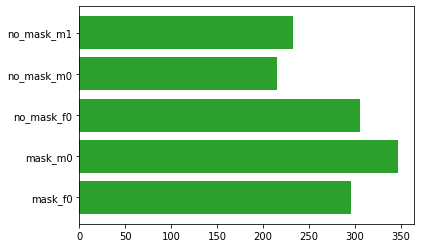

In [7]:
for i, class_name in enumerate(class_list):
    X = [] # Temporary list of instances
    y = [] # Temporary target list
    
    for l, d in enumerate(original_repo):
        if target[l] == class_name:
            X.append(d) # Add the instances for the current class
            y.append(class_name) # Add the target
    
    k = math.floor(class_count[i]/Avg + 1) # Number of clusters 
    
    if 1 < k < len(X): 
        kmeans = KMeans(n_clusters = k).fit(X)
        
        # Add decimals to the target representing the decomposition
        for j, n in enumerate(X):
            y[j] = y[j] + str(kmeans.labels_[j])
    
    else:
        for t, m in enumerate(X):
            y[t] = y[t] + str('0')
    cl_decompose = cl_decompose + y
    
print('The class decomposed target list size: ', len(cl_decompose))


#Counting the instances for each class
decomp_class_list, decomp_class_count = np.unique(cl_decompose, return_counts = True)

print('\n', decomp_class_list,'\n', decomp_class_count)
plt.barh(decomp_class_list, decomp_class_count, color = 'tab:green')  


Now, we obtained a target list splitting the data into __five__ classes and the classes do not have a big difference in the number of instances.

## 3. Performance metrics
The comparison between the models will be based mainly on comparing the __F1-score__ for Precision and Recall. F1-score is calculated as follows:

$$ F1 = 2 \times \frac{Precision\times Recall}{Precision + Recall} = \frac{2\times TP}{2\times TP + FP + FN}$$

Where:
- TP - True Positive instances
- FP - False Positive instances
- FN - False Negative instances

Accuracy, Precision, and Recall will be printed, but as not all the data repositories are balanced, these metrics will not be of help picking the best combination.

## 4. Train models
In this section, we will define, train, and test four different models with the repositories created. The four models will be based on different machine learning algorithms and they are as follows:

__1. Support Vector Machine__
The model will be build using a linear kernel as of the study done by Ramakrishnan and Sankaragomathi (2017) with the conscious choice that in this set-up, there will not bet attempts in optimising the model. More on the algorithm and other parameters that can be used can be found on [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

__2. Random Forest__
Training models with several iteration steps over other several iteration steps are time and resources consuming. Therefore, for the model using Random Forest algorithm, the number of trees is set to 30, even if knowing that increasing the number of trees, the better is model. More on the algorithm and other parameters that can be used can be found on [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

__3. Neural Network__
This model will as well use a build-in algorithm from `sklearn` package. The dataset is relatively small, but when picking the solver, the optimizer 'lbfgs' has a limit of 200 instances. Therefore, the stochastic gradient-based optimizer `'adam'` was picked. The activation function is the rectified linear unit function: $f(x) = max(0,x)$. The learning rate\ `alpha` is set to 0.005. More on the algorithm and other parameters that can be used can be found on [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).

__4. Convolutional Neural Network__
The fourth model will not use a build-in algorithm, but I will show the steps to build a CNN model. The CNN models work with the pixels of the images, therefore, a step of pre-processing the data is needed where we unflatten the repositories with the data on the pixels. Meaning that the repository with the HOG features will not be used with this particular model. In building the model, the same activation function will be used as in the NN model, namely, the rectified linear unit function. Followed by fitting and predicting. The development of the model is done by adding methods to the model `Sequential` part of the [keras models](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

In [21]:
## Define models
# Support Vector Machine
from sklearn.svm import SVC

model_svm = SVC(kernel = 'linear')



# Random Forest
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators = 30, random_state = 500)



# Neural Network
from sklearn.neural_network import MLPClassifier

model_nn = MLPClassifier(solver = 'adam', activation = 'relu', alpha = 0.005, random_state = 500)

"""
SVM and RF and NN work with vectorised features
"""


# Convolutional Neural Nerwork
"""
CNN uses only the repositories that stored pixels in the unflattened shape
"""
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

def model_cnn (X_train, y_train, X_test, y_test):
    ## Pre-process input data
    # Reshape into 4 dimensions
    X_train_4D = X_train.reshape(X_train.shape[0], standard_height, standard_width, 1)
    X_text_4D = X_test.reshape(X_test.shape[0], standard_height, standard_width, 1)
    # Converting to float 32
    X_train_4D = X_train_4D.astype('float32')
    X_test_4D = X_test_4D.astype('float32')
    #normalise
    X_train_4D = X_train_4D / 255
    X_test_4D = X_test_4D / 255
    
    ## Model build
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (standard_height, standard_width, 1)))
    model.add(Conv2d(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2d(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'relu'))
    
    ## Compile model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'precision', 'recall'])
    
    ## Fit model
    model.fit(X_train_4D, y_train, batch_size = 32, epochs = 5)
    
    ## Predict labels
    model.predict_classes(X_test_4D)
    
    return model

### 4.1. Experimental setting

With the models defined, we want to split the data into `training` and `testing`. The split needs to be stratified (having an equal percentage of instances from each class) so the models will not build-up a bias towards a certain class. However, we want to avoid the results being "by chance", so we will experiment the combinations of data and models using Cross-Validation. Meaning, we will create several stratified splits into `training` and `testing` data and apply the models to each one of them.


### 4.2. Gather evaluation metrics
In the following code cell, we will be printing the performance metrics for each combination of data and model. The evaluation will be done as __one vs all__ on the multi-class problem.

In [20]:
#models = [model_svm, model_rf, model_nn, model_cnn]
models = [model_svm, model_rf, model_nn]
scores = ['f1_micro', 'accuracy', 'precision_micro', 'recall_micro'] # `_micro` added as the problem is a multi-class problem
 
for m, i in enumerate(models):
    #if i != model_cnn:
        for j in scores:
            print('The mean ' + str(j) + ' for the original repository on ' + str(models[m]) + ': ', np.mean(cross_val_score(i, original_repo, target, cv = 5, scoring = j)))
            print('The mean ' + str(j) + ' for the threshold repository on ' + str(models[m]) + ': ', np.mean(cross_val_score(i, thresh_repo, target, cv = 5, scoring = j)))
            print('The mean ' + str(j) + ' for the HOG features repository on ' + str(models[m]) + ': ', np.mean(cross_val_score(i, hog_repo, target, cv = 5, scoring = j)))
            print('The mean ' + str(j) + ' for the augmented repository with the augmented target on ' + str(models[m]) + ': ', np.mean(cross_val_score(i, aug_repo, aug_target, cv = 5, scoring = j)))
            print('The mean ' + str(j) + ' for the original repository with the decomposed classes target on ' + str(models[m]) + ': ', np.mean(cross_val_score(i, original_repo, cl_decompose, cv = 5, scoring = j)))
            print('\n')
    #else:
     #   for j in scores:
      #      print('The mean' + str(j) + 'for the original repository on ' + str(i) + ': ', np.mean(cross_val_score(i, original_repo, target, cv = 5, scoring = j)))
       #     print('The mean' + str(j) + 'for the threshold repository on ' + str(i) + ': ', np.mean(cross_val_score(i, thresh_repo, target, cv = 5, scoring = j)))
        #    print('The mean' + str(j) + 'for the augmented repository with the augmented target on ' + str(i) + ': ', np.mean(cross_val_score(i, aug_repo, aug_target, cv = 5, scoring = j)))
         #   print('The mean' + str(j) + 'for the original repository with the decomposed classes target on ' + str(i) + ': ', np.mean(cross_val_score(i, original_repo, cl_decompose, cv = 5, scoring = j)))
          #  print('\n')


The mean f1_micro for the original repository on SVC(kernel='linear'):  0.5921146953405019
The mean f1_micro for the threshold repository on SVC(kernel='linear'):  0.5261648745519713
The mean f1_micro for the HOG features repository on SVC(kernel='linear'):  0.7318996415770609
The mean f1_micro for the augmented repository with the augmented target on SVC(kernel='linear'):  0.6073846298295854
The mean f1_micro for the original repository with the decomposed classes target on SVC(kernel='linear'):  0.5813620071684589


The mean accuracy for the original repository on SVC(kernel='linear'):  0.5921146953405019
The mean accuracy for the threshold repository on SVC(kernel='linear'):  0.5261648745519713
The mean accuracy for the HOG features repository on SVC(kernel='linear'):  0.7318996415770609
The mean accuracy for the augmented repository with the augmented target on SVC(kernel='linear'):  0.6073846298295854
The mean accuracy for the original repository with the decomposed classes target

## 5. Evaluation and comments

Following the output, we can see that the best value of the `F1-score` is for the combination __SVM on the HOG features__. 

Unfortunately, for the time being, the fourth model was unsuccessfully implemented. The code for obtaining the metrics remains commented out for later solving the issue in building the model.


### 5.1. Reasons for low results
The results so far are due to raw model implementation and there is no attempt to tune the model parameter, besides the build-in tunning of the algorithm functions. 

The repositories created might not be the best for face recognition. For example, instead of applying threshold, finding the edges might have been more suitable.

Another reason for which the models perform poorly is the image quality that was fed to the models. As the images come from two different online repositories, the image resolutions will be different, the lighting on the face might inhibit the feature detection. And some of the images are professionally taken photos, so it is expected they will have artificially modified pixels that will stand out.

And the last reason is ethnicity imbalance. The two datasets do not have an equal share in the data used, so the majority of ethnicity is Chinese.

All these said the results can be increased with consistent data. For example, using the images from security cameras of the same model will provide raw images with low variation in lighting and resolution.

### 5.2. Future work
With an unimplemented model, this will be the first issue to tackle. The next step is to apply tunning methods on the models for better parameter fit.

If thinking of real application, as using raw images from security cameras, there should be applied a face recognition algorithm to crop the face, and then build the repositories.


## Bibliography
RAMAKRISHNAN, T. and SANKARAGOMATHI, B., 2017. A professional estimate on the computed tomography brain tumor images using SVM-SMO for classification and MRG-GWO for segmentation. Pattern Recognition Letters, 94, pp. 163-171
